# Plotting notebook: Speaker role geometric structure (from saved outputs)

This notebook **does not load models**.
It loads saved activations from `speaker-tracking/outputs/geometric_structure/` and produces cleaner figures:
- separability heatmaps (per model + side-by-side)
- accuracy vs layer curves (per token-position)
- PCA scatter with centroids (optionally for specific layer/position)
- 1D projection plots along the (Alice−Bob) direction

Inputs created by: `030226_geometric_structure.ipynb`


In [30]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

np.random.seed(7)


In [31]:
NOTEBOOK_DIR = Path(".").resolve()  # speaker-tracking/notebooks/
SPEAKER_TRACKING_DIR = NOTEBOOK_DIR.parent

# Outputs may live either:
# - next to this notebook:   notebooks/outputs/geometric_structure/
# - at speaker-tracking/:    speaker-tracking/outputs/geometric_structure/
CANDIDATE_OUT_DIRS = [
    NOTEBOOK_DIR / "outputs" / "geometric_structure",
    SPEAKER_TRACKING_DIR / "outputs" / "geometric_structure",
]
OUT_DIR = next((p for p in CANDIDATE_OUT_DIRS if p.exists()), CANDIDATE_OUT_DIRS[0])

FIG_DIR = NOTEBOOK_DIR / "outputs" / "figures" / "geometric_structure"
FIG_DIR.mkdir(parents=True, exist_ok=True)

summary = json.loads((OUT_DIR / "SUMMARY.json").read_text())
print("Using OUT_DIR:", OUT_DIR)
print("Saving figures to:", FIG_DIR)
summary

Using OUT_DIR: /Users/jessebafernando/Dropbox/My Mac (Jesseba’s MacBook Pro)/Documents/GitHub/role-representation/speaker-tracking/notebooks/outputs/geometric_structure
Saving figures to: /Users/jessebafernando/Dropbox/My Mac (Jesseba’s MacBook Pro)/Documents/GitHub/role-representation/speaker-tracking/notebooks/outputs/figures/geometric_structure


{'qwen_7b': {'npz': 'outputs/geometric_structure/qwen_7b_layerpos_data.npz',
  'meta': 'outputs/geometric_structure/qwen_7b_meta.json',
  'num_layerpos': 10},
 'qwen_2_5': {'npz': 'outputs/geometric_structure/qwen_2_5_layerpos_data.npz',
  'meta': 'outputs/geometric_structure/qwen_2_5_meta.json',
  'num_layerpos': 10},
 'llama_3_1_8b': {'npz': 'outputs/geometric_structure/llama_3_1_8b_layerpos_data.npz',
  'meta': 'outputs/geometric_structure/llama_3_1_8b_meta.json',
  'num_layerpos': 10}}

In [32]:
def _resolve_path(p: Path) -> Path:
    if p.is_absolute():
        return p
    # try relative to notebook dir, speaker-tracking dir, and OUT_DIR parent
    candidates = [
        (NOTEBOOK_DIR / p).resolve(),
        (SPEAKER_TRACKING_DIR / p).resolve(),
        (OUT_DIR.parent / p).resolve(),
    ]
    for c in candidates:
        if c.exists():
            return c
    return candidates[0]


def load_model_npz(model_key: str):
    npz_path = _resolve_path(Path(summary[model_key]["npz"]))
    data = np.load(npz_path, allow_pickle=True)

    meta_path = _resolve_path(Path(summary[model_key]["meta"]))
    meta = json.loads(meta_path.read_text())
    return data, meta


def list_layerpos_keys(npz) -> list[tuple[int, str]]:
    # keys look like: layer14__posverb__X / __y
    out = set()
    for k in npz.files:
        if k.endswith("__X"):
            core = k[:-3]
            layer_str, pos_str = core.split("__")
            layer = int(layer_str.replace("layer", ""))
            pos = pos_str.replace("pos", "")
            out.add((layer, pos))
    return sorted(out)


def get_xy(npz, layer: int, pos: str):
    core = f"layer{layer}__pos{pos}"
    X = npz[f"{core}__X"]
    y = npz[f"{core}__y"].astype(str)
    return X, y


def compute_separability_from_npz(npz) -> pd.DataFrame:
    rows = []
    for layer, pos in list_layerpos_keys(npz):
        X, y = get_xy(npz, layer, pos)
        y_bin = (y == "Alice").astype(int)
        classes, counts = np.unique(y_bin, return_counts=True)
        if len(classes) < 2 or counts.min() < 2:
            continue
        n_splits = min(5, int(counts.min()))
        if n_splits < 2:
            continue
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
        accs = []
        for tr, te in cv.split(X, y_bin):
            if len(np.unique(y_bin[tr])) < 2 or len(np.unique(y_bin[te])) < 2:
                continue
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X[tr], y_bin[tr])
            accs.append(accuracy_score(y_bin[te], clf.predict(X[te])))
        if accs:
            rows.append({"layer": layer, "position": pos, "accuracy": float(np.mean(accs))})
    return pd.DataFrame(rows)


In [33]:
# Load all models
loaded = {}
for model_key in summary.keys():
    npz, meta = load_model_npz(model_key)
    loaded[model_key] = {"npz": npz, "meta": meta}

{mk: len(loaded[mk]["npz"].files) for mk in loaded}

{'qwen_7b': 20, 'qwen_2_5': 20, 'llama_3_1_8b': 20}

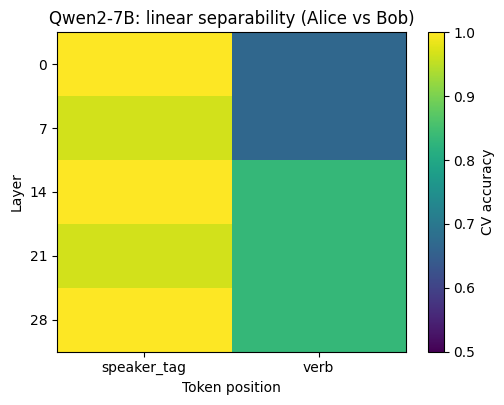

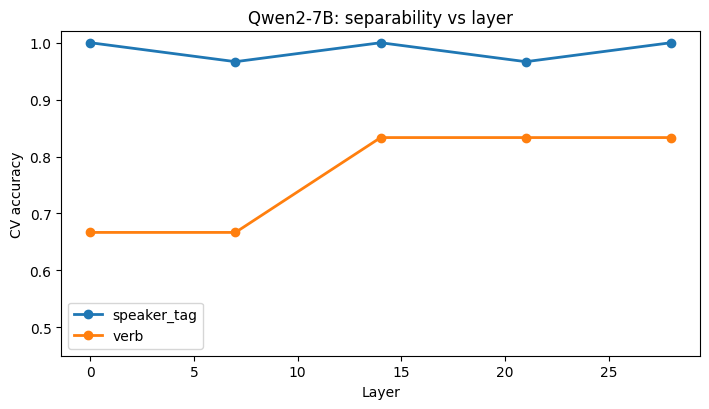

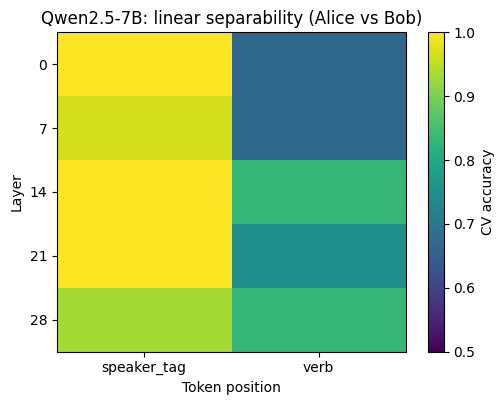

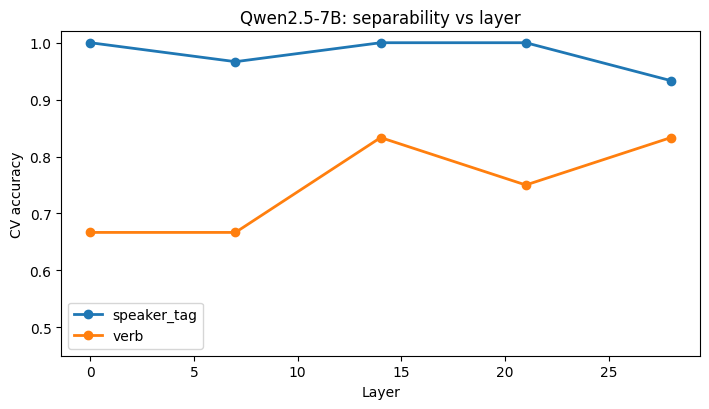

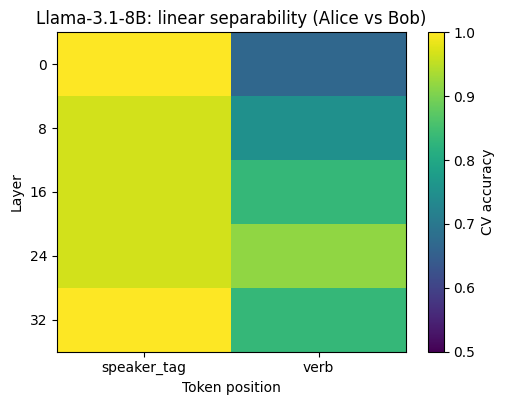

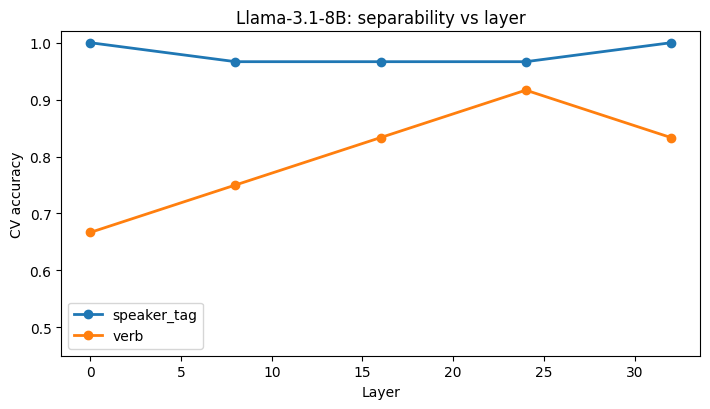

In [34]:
PRETTY_MODEL = {
    "qwen_7b": "Qwen2-7B",
    "qwen_2_5": "Qwen2.5-7B",
    "llama_3_1_8b": "Llama-3.1-8B",
}


def plot_heatmap(df: pd.DataFrame, title: str, save_path: Path | None = None):
    """Presentation version: no numeric annotations."""
    if df.empty:
        print(f"No data for {title}")
        return

    pivot = df.pivot(index="layer", columns="position", values="accuracy").sort_index()

    fig, ax = plt.subplots(figsize=(1.1 * len(pivot.columns) + 3.0, 0.35 * len(pivot.index) + 2.4))
    im = ax.imshow(pivot.values, cmap="viridis", vmin=0.5, vmax=1.0, aspect="auto")

    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)

    ax.set_title(title)
    ax.set_xlabel("Token position")
    ax.set_ylabel("Layer")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("CV accuracy")

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=250)
    plt.show()


def plot_accuracy_vs_layer(df: pd.DataFrame, title: str, save_path: Path | None = None):
    if df.empty:
        print(f"No data for {title}")
        return

    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    for pos, g in df.groupby("position"):
        g = g.sort_values("layer")
        ax.plot(g["layer"], g["accuracy"], marker="o", linewidth=2, label=pos)

    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("CV accuracy")
    ax.set_ylim(0.45, 1.02)
    ax.grid(False)
    ax.legend(loc="best", frameon=True)

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=250)
    plt.show()


seps = {}
for mk, obj in loaded.items():
    df = compute_separability_from_npz(obj["npz"])
    seps[mk] = df
    name = PRETTY_MODEL.get(mk, mk)
    plot_heatmap(df, f"{name}: linear separability (Alice vs Bob)", save_path=FIG_DIR / f"{mk}_heatmap.png")
    plot_accuracy_vs_layer(df, f"{name}: separability vs layer", save_path=FIG_DIR / f"{mk}_layercurves.png")


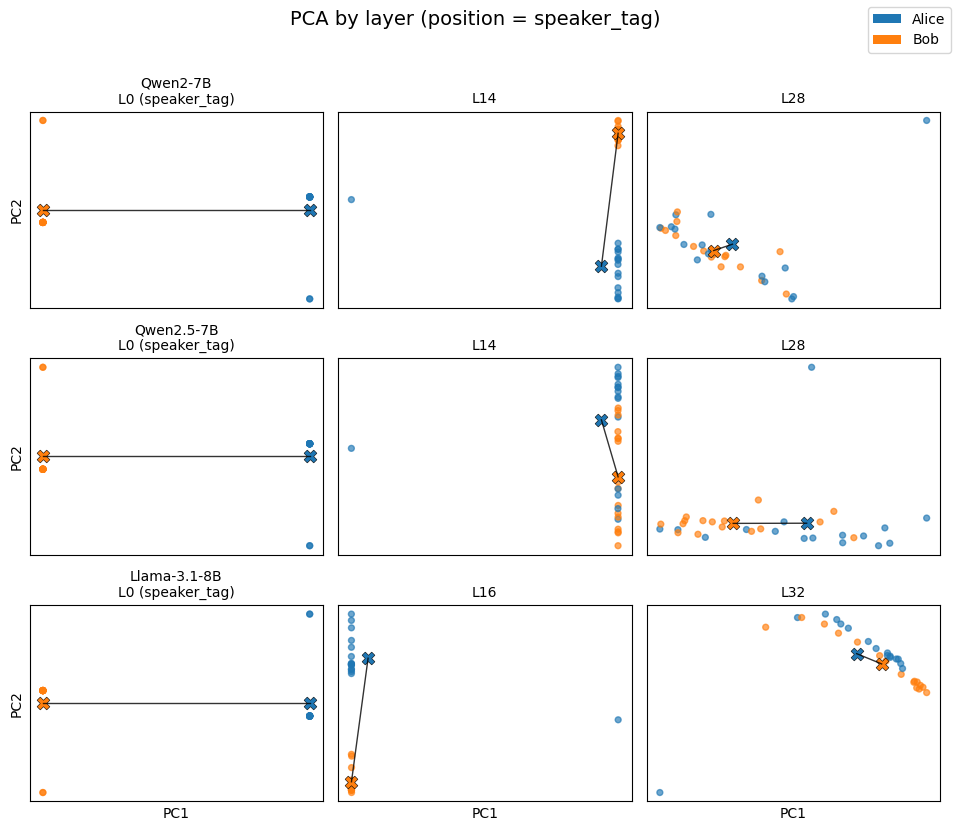

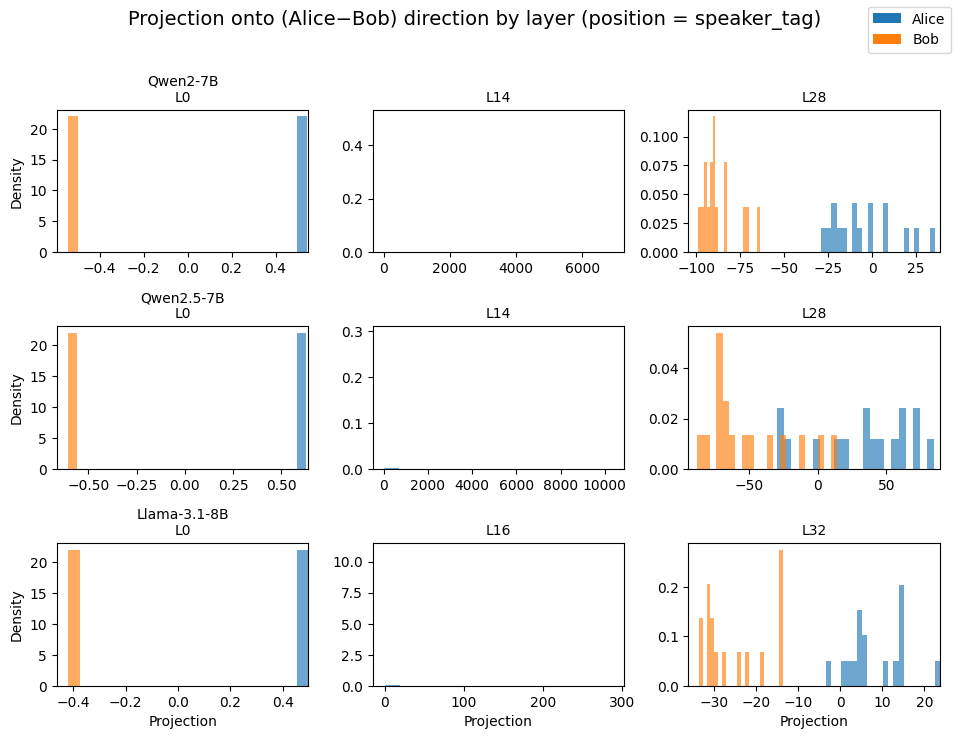

In [41]:
from matplotlib.patches import Patch


def pca_scatter_with_centroids_ax(ax, X: np.ndarray, y: np.ndarray, title: str, show_xlabel: bool, show_ylabel: bool):
    pca = PCA(n_components=2)
    X2 = pca.fit_transform(X)

    colors = np.where(y == "Alice", "tab:blue", "tab:orange")
    ax.scatter(X2[:, 0], X2[:, 1], c=colors, alpha=0.65, s=18)

    a = X2[y == "Alice"].mean(axis=0)
    b = X2[y == "Bob"].mean(axis=0)
    ax.scatter([a[0]], [a[1]], c="tab:blue", s=85, marker="X", edgecolor="k", linewidth=0.4)
    ax.scatter([b[0]], [b[1]], c="tab:orange", s=85, marker="X", edgecolor="k", linewidth=0.4)
    ax.plot([a[0], b[0]], [a[1], b[1]], color="k", linewidth=1.0, alpha=0.8)

    ax.set_title(title, fontsize=10)
    ax.grid(False)

    # ticks off, labels on outer edges
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("PC1" if show_xlabel else "")
    ax.set_ylabel("PC2" if show_ylabel else "")


def projection_ecdf_ax(
    ax,
    X: np.ndarray,
    y: np.ndarray,
    title: str,
    show_xlabel: bool,
    show_ylabel: bool,
):
    a = X[y == "Alice"].mean(axis=0)
    b = X[y == "Bob"].mean(axis=0)
    d = a - b
    d = d / (np.linalg.norm(d) + 1e-12)
    proj = X @ d

    def _ecdf(vals: np.ndarray):
        v = np.sort(vals)
        n = len(v)
        if n == 0:
            return v, v
        y = np.arange(1, n + 1) / n
        return v, y

    x_a, y_a = _ecdf(proj[y == "Alice"])
    x_b, y_b = _ecdf(proj[y == "Bob"])

    ax.plot(x_a, y_a, color="tab:blue", linewidth=2)
    ax.plot(x_b, y_b, color="tab:orange", linewidth=2)

    lo, hi = np.percentile(proj, [1, 99])
    pad = 0.05 * (hi - lo + 1e-9)
    ax.set_xlim(lo - pad, hi + pad)
    ax.set_ylim(0, 1)

    ax.set_title(title, fontsize=10)
    ax.grid(False)
    ax.set_xlabel("Projection" if show_xlabel else "")
    ax.set_ylabel("ECDF" if show_ylabel else "")


def _closest_layer(target: int, available: list[int]) -> int | None:
    if not available:
        return None
    return min(available, key=lambda x: abs(x - target))


def _available_layers_for_pos(npz, pos: str) -> list[int]:
    return sorted({layer for (layer, p) in list_layerpos_keys(npz) if p == pos})


# Grid settings
GRID_LAYERS = [0, 16, 32]
GRID_POS = "speaker_tag"  # or: "verb" / "final"
GRID_LAYER_MODE = "closest"  # "closest" or "exact"

model_keys = list(loaded.keys())

legend_elems = [
    Patch(facecolor="tab:blue", label="Alice"),
    Patch(facecolor="tab:orange", label="Bob"),
]

# --- PCA grid (rows=models, cols=layers) ---
fig, axes = plt.subplots(
    len(model_keys),
    len(GRID_LAYERS),
    figsize=(3.2 * len(GRID_LAYERS), 2.7 * len(model_keys)),
)
if len(model_keys) == 1:
    axes = np.array([axes])

for r, mk in enumerate(model_keys):
    npz = loaded[mk]["npz"]
    avail = _available_layers_for_pos(npz, GRID_POS)
    for c, L in enumerate(GRID_LAYERS):
        ax = axes[r, c]
        layer = L if GRID_LAYER_MODE == "exact" else _closest_layer(L, avail)
        if layer is None or (layer, GRID_POS) not in list_layerpos_keys(npz):
            ax.axis("off")
            continue

        X, y = get_xy(npz, layer, GRID_POS)
        model_name = PRETTY_MODEL.get(mk, mk)
        title = f"{model_name}\nL{layer} ({GRID_POS})" if c == 0 else f"L{layer}"
        pca_scatter_with_centroids_ax(
            ax,
            X,
            y,
            title,
            show_xlabel=(r == len(model_keys) - 1),
            show_ylabel=(c == 0),
        )

fig.suptitle(f"PCA by layer (position = {GRID_POS})", y=1.02, fontsize=14)
fig.legend(handles=legend_elems, loc="upper right", frameon=True)
plt.tight_layout()
fig.savefig(FIG_DIR / f"GRID_PCA_{GRID_POS}.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Projection grid (rows=models, cols=layers) ---
fig, axes = plt.subplots(
    len(model_keys),
    len(GRID_LAYERS),
    figsize=(3.2 * len(GRID_LAYERS), 2.4 * len(model_keys)),
)
if len(model_keys) == 1:
    axes = np.array([axes])

for r, mk in enumerate(model_keys):
    npz = loaded[mk]["npz"]
    avail = _available_layers_for_pos(npz, GRID_POS)
    for c, L in enumerate(GRID_LAYERS):
        ax = axes[r, c]
        layer = L if GRID_LAYER_MODE == "exact" else _closest_layer(L, avail)
        if layer is None or (layer, GRID_POS) not in list_layerpos_keys(npz):
            ax.axis("off")
            continue

        X, y = get_xy(npz, layer, GRID_POS)
        model_name = PRETTY_MODEL.get(mk, mk)
        title = f"{model_name}\nL{layer}" if c == 0 else f"L{layer}"
        projection_ecdf_ax(
            ax,
            X,
            y,
            title,
            show_xlabel=(r == len(model_keys) - 1),
            show_ylabel=(c == 0),
        )

fig.suptitle(f"Projection onto (Alice−Bob) direction by layer (position = {GRID_POS})", y=1.02, fontsize=14)
fig.legend(handles=legend_elems, loc="upper right", frameon=True)
plt.tight_layout()
fig.savefig(FIG_DIR / f"GRID_PROJ_{GRID_POS}.png", dpi=300, bbox_inches="tight")
plt.show()


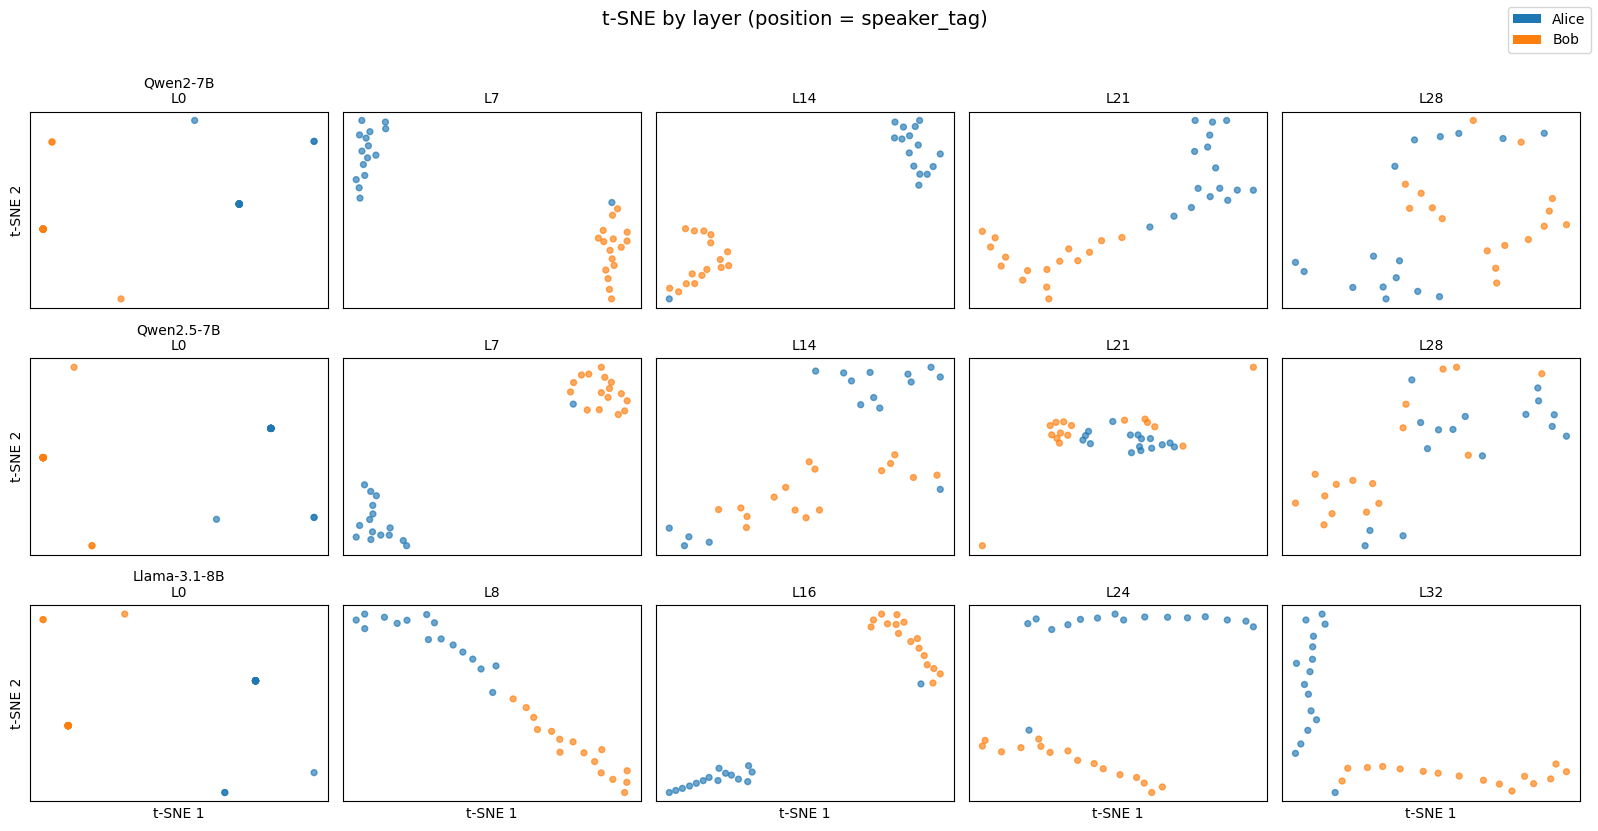

In [36]:
def tsne_scatter_ax(
    ax,
    X: np.ndarray,
    y: np.ndarray,
    title: str,
    show_xlabel: bool,
    show_ylabel: bool,
    perplexity: int | None = None,
):
    n = len(X)
    if perplexity is None:
        perplexity = int(np.clip(n // 10, 5, 50))
    perplexity = min(perplexity, max(2, (n - 1) // 3))

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init="pca",
        learning_rate="auto",
        random_state=7,
    )
    X2 = tsne.fit_transform(X)

    colors = np.where(y == "Alice", "tab:blue", "tab:orange")
    ax.scatter(X2[:, 0], X2[:, 1], c=colors, alpha=0.65, s=18)

    ax.set_title(title, fontsize=10)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("t-SNE 1" if show_xlabel else "")
    ax.set_ylabel("t-SNE 2" if show_ylabel else "")


# --- t-SNE grid (rows=models, cols=layers) ---
TSNE_POS = GRID_POS
TSNE_LAYER_MODE = GRID_LAYER_MODE
TSNE_PERPLEXITY = None  # set int for fixed perplexity

model_keys = list(loaded.keys())
fig, axes = plt.subplots(
    len(model_keys),
    len(GRID_LAYERS),
    figsize=(3.2 * len(GRID_LAYERS), 2.7 * len(model_keys)),
)
if len(model_keys) == 1:
    axes = np.array([axes])

for r, mk in enumerate(model_keys):
    npz = loaded[mk]["npz"]
    avail = _available_layers_for_pos(npz, TSNE_POS)
    for c, L in enumerate(GRID_LAYERS):
        ax = axes[r, c]
        layer = L if TSNE_LAYER_MODE == "exact" else _closest_layer(L, avail)
        if layer is None or (layer, TSNE_POS) not in list_layerpos_keys(npz):
            ax.axis("off")
            continue

        X, y = get_xy(npz, layer, TSNE_POS)
        model_name = PRETTY_MODEL.get(mk, mk)
        title = f"{model_name}\nL{layer}" if c == 0 else f"L{layer}"
        tsne_scatter_ax(
            ax,
            X,
            y,
            title,
            show_xlabel=(r == len(model_keys) - 1),
            show_ylabel=(c == 0),
            perplexity=TSNE_PERPLEXITY,
        )

fig.suptitle(f"t-SNE by layer (position = {TSNE_POS})", y=1.02, fontsize=14)
fig.legend(handles=legend_elems, loc="upper right", frameon=True)
plt.tight_layout()
fig.savefig(FIG_DIR / f"GRID_TSNE_{TSNE_POS}.png", dpi=300, bbox_inches="tight")
plt.show()


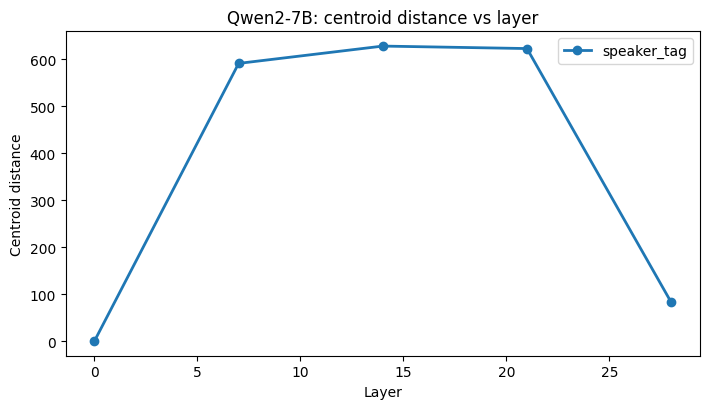

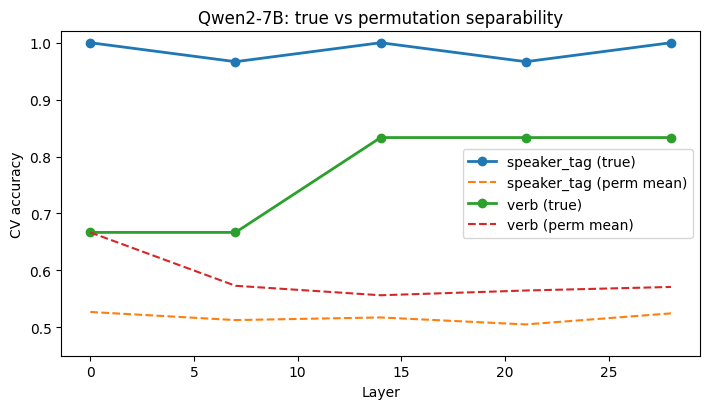

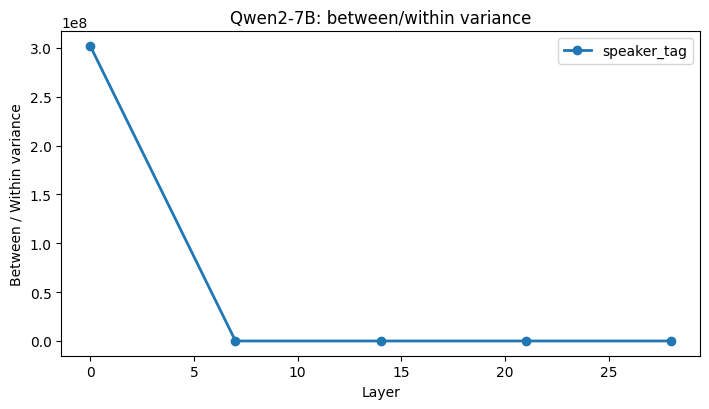

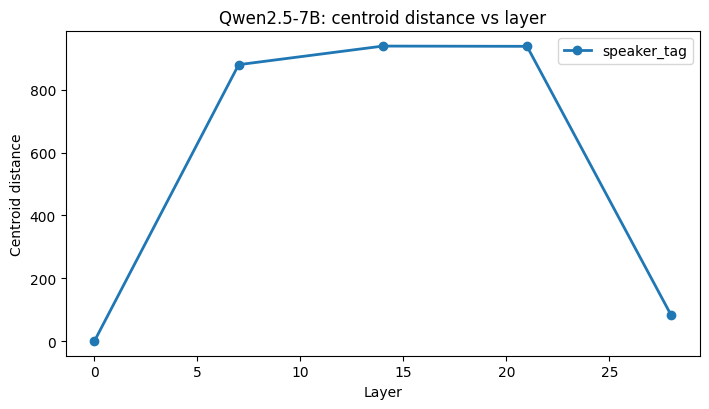

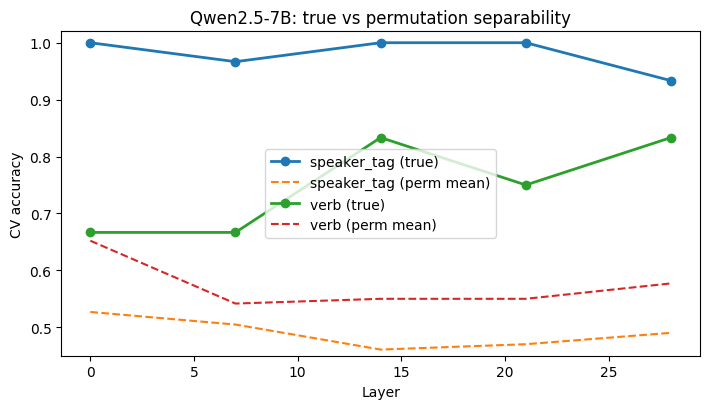

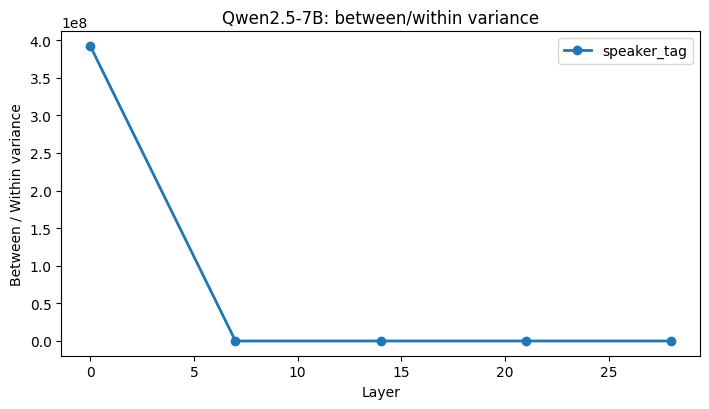

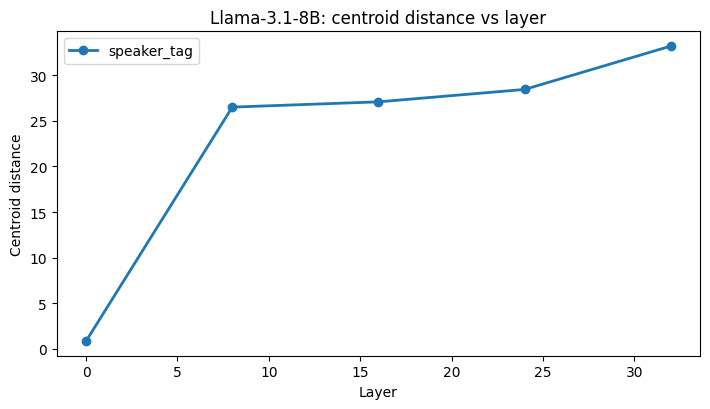

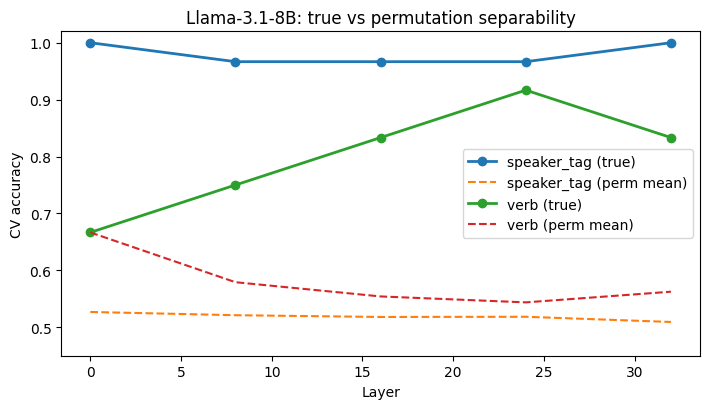

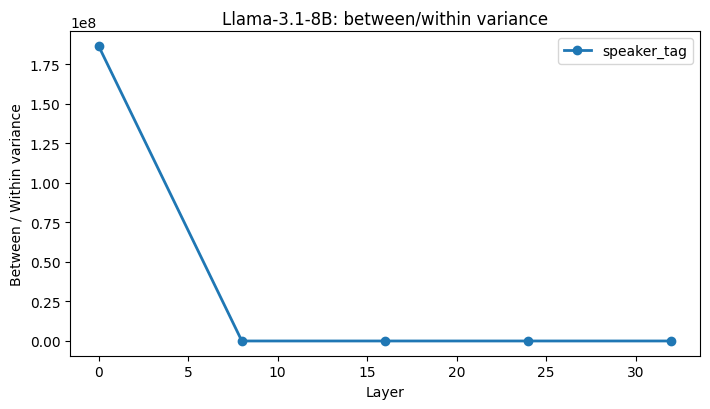

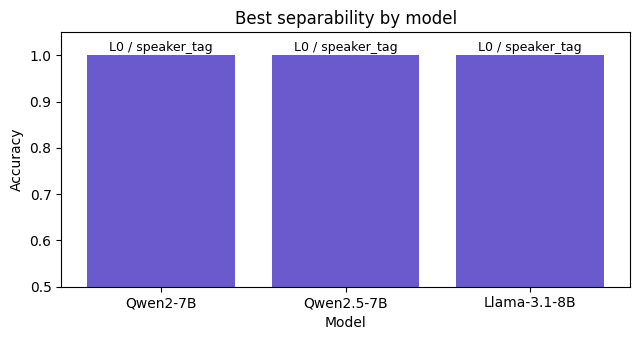

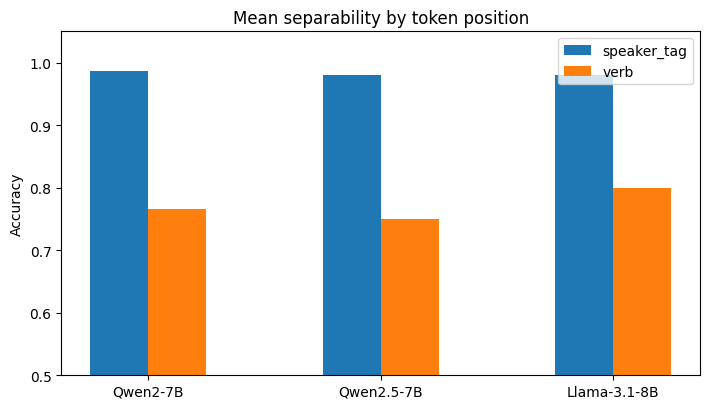

In [42]:
# --- Additional analyses ---

from matplotlib.patches import Patch

# 1) Layer-wise centroid distance (||mean(Alice) - mean(Bob)||)

def centroid_distance_by_layer(npz, pos: str) -> pd.DataFrame:
    rows = []
    for layer, p in list_layerpos_keys(npz):
        if p != pos:
            continue
        X, y = get_xy(npz, layer, pos)
        if len(set(y.tolist())) < 2:
            continue
        a = X[y == "Alice"].mean(axis=0)
        b = X[y == "Bob"].mean(axis=0)
        dist = float(np.linalg.norm(a - b))
        rows.append({"layer": int(layer), "position": pos, "centroid_dist": dist})
    return pd.DataFrame(rows)


def plot_centroid_distance(df: pd.DataFrame, title: str, save_path: Path | None = None):
    if df.empty:
        print(f"No data for {title}")
        return
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    for pos, g in df.groupby("position"):
        g = g.sort_values("layer")
        ax.plot(g["layer"], g["centroid_dist"], marker="o", linewidth=2, label=pos)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Centroid distance")
    ax.grid(False)
    ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()


# 2) Permutation baseline for separability

def compute_separability_with_permutation(npz, n_perm: int = 50) -> pd.DataFrame:
    rows = []
    for layer, pos in list_layerpos_keys(npz):
        X, y = get_xy(npz, layer, pos)
        y_bin = (y == "Alice").astype(int)
        classes, counts = np.unique(y_bin, return_counts=True)
        if len(classes) < 2 or counts.min() < 2:
            continue
        n_splits = min(5, int(counts.min()))
        if n_splits < 2:
            continue
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)

        # true accuracy
        accs = []
        for tr, te in cv.split(X, y_bin):
            if len(np.unique(y_bin[tr])) < 2 or len(np.unique(y_bin[te])) < 2:
                continue
            clf = LogisticRegression(max_iter=1000)
            clf.fit(X[tr], y_bin[tr])
            accs.append(accuracy_score(y_bin[te], clf.predict(X[te])))
        if not accs:
            continue
        acc_true = float(np.mean(accs))

        # permutation baseline
        perm_accs = []
        rng = np.random.default_rng(7)
        for _ in range(n_perm):
            y_perm = y_bin.copy()
            rng.shuffle(y_perm)
            accs_p = []
            for tr, te in cv.split(X, y_perm):
                if len(np.unique(y_perm[tr])) < 2 or len(np.unique(y_perm[te])) < 2:
                    continue
                clf = LogisticRegression(max_iter=1000)
                clf.fit(X[tr], y_perm[tr])
                accs_p.append(accuracy_score(y_perm[te], clf.predict(X[te])))
            if accs_p:
                perm_accs.append(float(np.mean(accs_p)))
        if not perm_accs:
            continue

        rows.append({
            "layer": int(layer),
            "position": pos,
            "acc_true": acc_true,
            "acc_perm_mean": float(np.mean(perm_accs)),
            "acc_perm_std": float(np.std(perm_accs)),
        })
    return pd.DataFrame(rows)


def plot_perm_baseline(df: pd.DataFrame, title: str, save_path: Path | None = None):
    if df.empty:
        print(f"No data for {title}")
        return
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    for pos, g in df.groupby("position"):
        g = g.sort_values("layer")
        ax.plot(g["layer"], g["acc_true"], marker="o", linewidth=2, label=f"{pos} (true)")
        ax.plot(g["layer"], g["acc_perm_mean"], linestyle="--", linewidth=1.5, label=f"{pos} (perm mean)")
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("CV accuracy")
    ax.set_ylim(0.45, 1.02)
    ax.grid(False)
    ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()


# 3) Cross-model comparison: best layer/position

def best_layer_summary(seps_dict: dict) -> pd.DataFrame:
    rows = []
    for mk, df in seps_dict.items():
        if df is None or df.empty:
            continue
        best = df.sort_values("accuracy", ascending=False).iloc[0]
        rows.append({
            "model": PRETTY_MODEL.get(mk, mk),
            "best_layer": int(best["layer"]),
            "best_position": str(best["position"]),
            "best_accuracy": float(best["accuracy"]),
        })
    return pd.DataFrame(rows)


def plot_best_layer_summary(df: pd.DataFrame, save_path: Path | None = None):
    if df.empty:
        print("No best-layer data")
        return
    fig, ax = plt.subplots(figsize=(6.5, 3.5))
    ax.bar(df["model"], df["best_accuracy"], color="slateblue")
    for i, row in df.iterrows():
        ax.text(i, row["best_accuracy"] + 0.01, f"L{row['best_layer']} / {row['best_position']}", ha="center", fontsize=9)
    ax.set_ylim(0.5, 1.05)
    ax.set_title("Best separability by model")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Model")
    ax.grid(False)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()


# 4) Within-speaker vs between-speaker variance ratio

def variance_ratio_by_layer(npz, pos: str) -> pd.DataFrame:
    rows = []
    for layer, p in list_layerpos_keys(npz):
        if p != pos:
            continue
        X, y = get_xy(npz, layer, pos)
        if len(set(y.tolist())) < 2:
            continue
        a = X[y == "Alice"]
        b = X[y == "Bob"]
        if len(a) < 2 or len(b) < 2:
            continue
        # within-speaker variance (mean of per-dim variance)
        within = 0.5 * (a.var(axis=0).mean() + b.var(axis=0).mean())
        # between-speaker variance (mean squared distance between means)
        between = np.mean((a.mean(axis=0) - b.mean(axis=0)) ** 2)
        ratio = float(between / (within + 1e-12))
        rows.append({"layer": int(layer), "position": pos, "var_ratio": ratio})
    return pd.DataFrame(rows)


def plot_variance_ratio(df: pd.DataFrame, title: str, save_path: Path | None = None):
    if df.empty:
        print(f"No data for {title}")
        return
    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    for pos, g in df.groupby("position"):
        g = g.sort_values("layer")
        ax.plot(g["layer"], g["var_ratio"], marker="o", linewidth=2, label=pos)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Between / Within variance")
    ax.grid(False)
    ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()


# 5) Token-position comparison: mean separability per position

def plot_position_comparison(seps_dict: dict, save_path: Path | None = None):
    rows = []
    for mk, df in seps_dict.items():
        if df is None or df.empty:
            continue
        for pos, g in df.groupby("position"):
            rows.append({
                "model": PRETTY_MODEL.get(mk, mk),
                "position": pos,
                "mean_accuracy": float(g["accuracy"].mean()),
            })
    comp = pd.DataFrame(rows)
    if comp.empty:
        print("No data for position comparison")
        return

    fig, ax = plt.subplots(figsize=(7.2, 4.2))
    positions = sorted(comp["position"].unique())
    models = list(comp["model"].unique())

    x = np.arange(len(models))
    width = 0.25 if len(positions) <= 3 else 0.2

    for i, pos in enumerate(positions):
        vals = []
        for m in models:
            v = comp[(comp["model"] == m) & (comp["position"] == pos)]["mean_accuracy"]
            vals.append(float(v.iloc[0]) if len(v) else np.nan)
        ax.bar(x + i * width, vals, width=width, label=pos)

    ax.set_xticks(x + width * (len(positions) - 1) / 2)
    ax.set_xticklabels(models)
    ax.set_ylim(0.5, 1.05)
    ax.set_title("Mean separability by token position")
    ax.set_ylabel("Accuracy")
    ax.grid(False)
    ax.legend(loc="best", frameon=True)
    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=300)
    plt.show()


# ---- Run all extra analyses ----
for mk, obj in loaded.items():
    npz = obj["npz"]
    name = PRETTY_MODEL.get(mk, mk)

    # centroid distance
    cd = centroid_distance_by_layer(npz, pos=GRID_POS)
    plot_centroid_distance(cd, f"{name}: centroid distance vs layer", save_path=FIG_DIR / f"{mk}_centroid_distance.png")

    # permutation baseline
    perm = compute_separability_with_permutation(npz, n_perm=40)
    plot_perm_baseline(perm, f"{name}: true vs permutation separability", save_path=FIG_DIR / f"{mk}_perm_baseline.png")

    # variance ratio
    vr = variance_ratio_by_layer(npz, pos=GRID_POS)
    plot_variance_ratio(vr, f"{name}: between/within variance", save_path=FIG_DIR / f"{mk}_var_ratio.png")

# cross-model summary
best_df = best_layer_summary(seps)
plot_best_layer_summary(best_df, save_path=FIG_DIR / "best_layer_summary.png")

# position comparison
plot_position_comparison(seps, save_path=FIG_DIR / "position_comparison.png")
